In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import signal

In [6]:
df = pd.read_csv('Data//cursach//07.txt', sep = ' ', ).rename(columns={"-0.35793": 'Data'})
df.head(5)

,Data
0,-0.24496
1,0.10937
2,1.29380
3,1.38960
4,0.69561


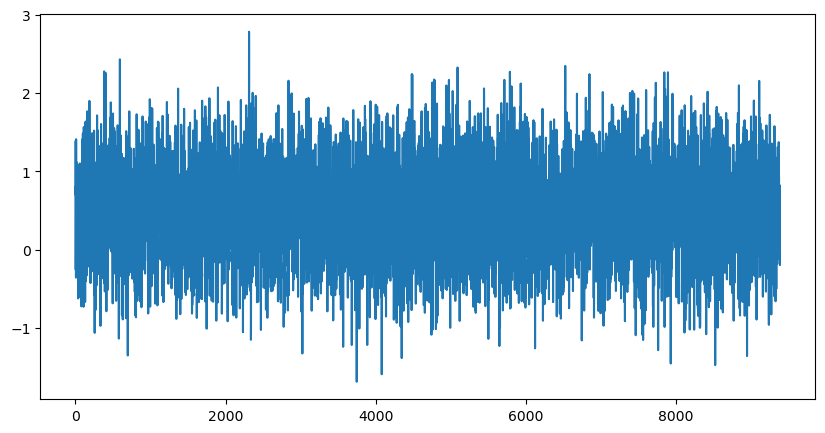

In [7]:
plt.figure(figsize = (10, 5))
plt.plot(df)

In [8]:
X = df['Data']
X

0      -0.244960
1       0.109370
2       1.293800
3       1.389600
4       0.695610
          ...   
9379   -0.056414
9380    0.243240
9381    0.469850
9382   -0.198080
9383   -0.052620
Name: Data, Length: 9384, dtype: float64

In [9]:
res = sm.tsa.stattools.kpss(df, nlags = 'auto')
print(f'p-value: {res[1]}')

p-value: 0.1


C:\Users\Shinik\AppData\Local\Temp\ipykernel_12888\683636322.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  res = sm.tsa.stattools.kpss(df, nlags = 'auto')


По тесту KPSS принимаем нулевую гипотезу о стационарности ряда

Посмотрим на периодограммы и спектрограммы исходного ряда

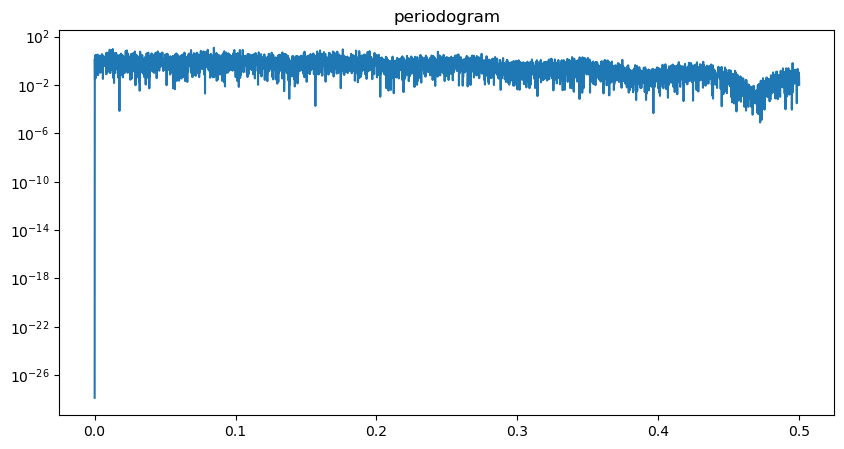

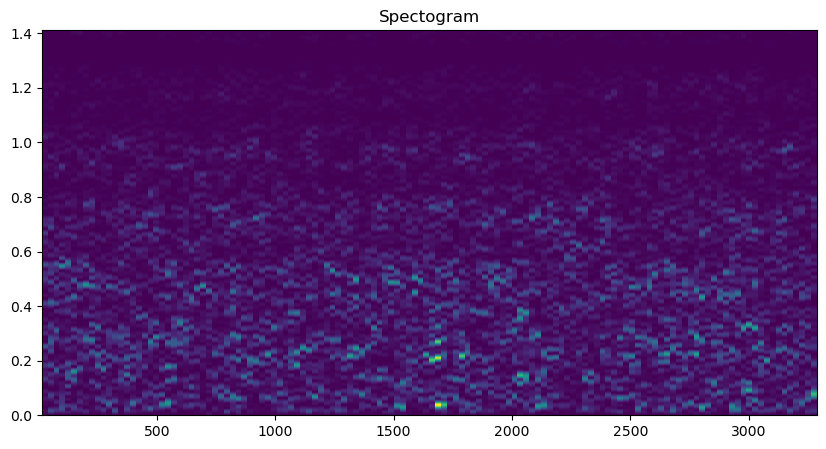

In [10]:
t = np.array(list(range(len(X))))
fs = 1/(X[1] - X[0])
f, tx, Sxx = signal.spectrogram(X, fs, nperseg = 150, noverlap = 80, nfft=4096)
pd, pdden = signal.periodogram(X) # периодограмма

analytic_signal = signal.hilbert(X)
inst_ampl = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase)/(2.0*np.pi)*fs)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))


plt.figure(figsize = (10, 5))
plt.semilogy(pd, pdden)
plt.title('periodogram')
plt.show()

plt.figure(figsize = (10, 5))
plt.pcolormesh(tx, f, Sxx, shading = 'auto')
plt.title('Spectogram')
plt.show()

Гилберт

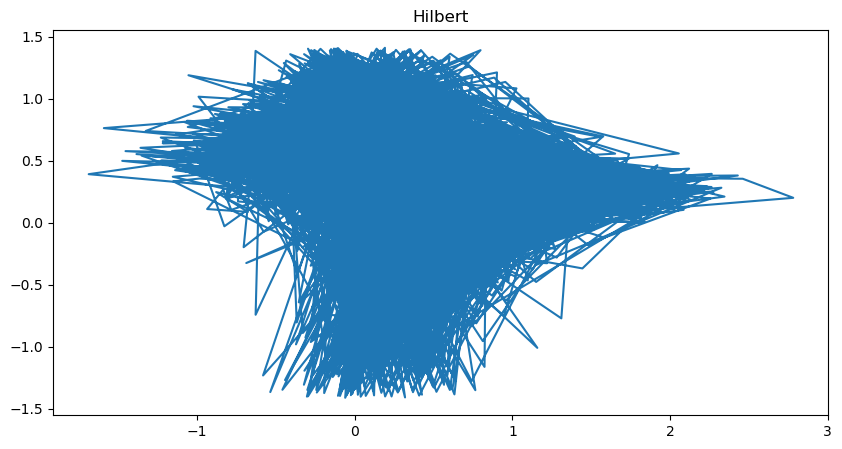

In [11]:
plt.figure(figsize = (10, 5))
plt.plot(X[1:], instantaneous_frequency[0:])
plt.title('Hilbert')
plt.show()

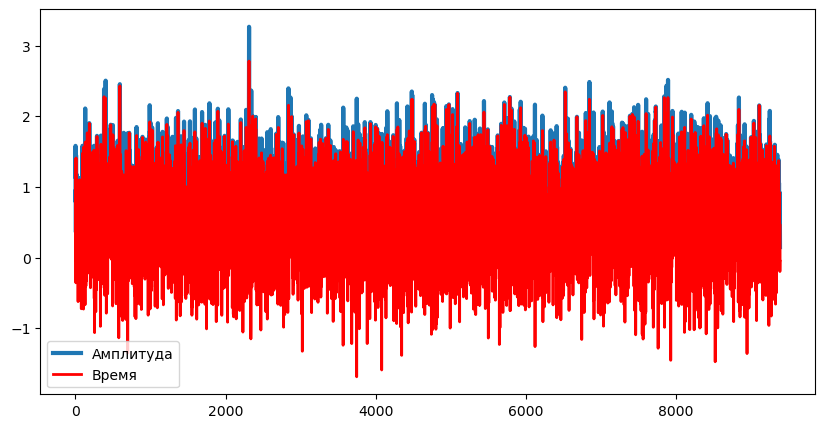

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(t[1:], inst_ampl[1:], label="Амплитуда", linewidth=3)
plt.plot(t[1:], X[1:], label="Время", linewidth=2, c = 'r')
plt.legend(loc="lower left")
plt.show()

Выделим тренд регрессией и сглаживанием

Регрессия

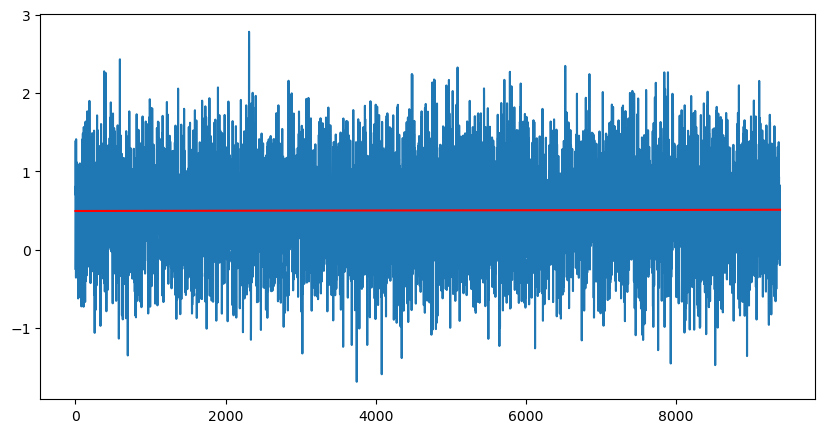

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


reg = LinearRegression().fit(t.reshape(-1, 1), X)
plt.figure(figsize=(10, 5))
plt.plot(t, X)
plt.plot(t, reg.predict(t.reshape(-1, 1)), c = 'r')

Сглаживание

In [20]:
def exp_smooth(x, a):
    w = [np.mean(x[0:2])]
    for i in range(1, len(x)):
        w.append((1 - a) * w[-1] + a * x[i])
    return w


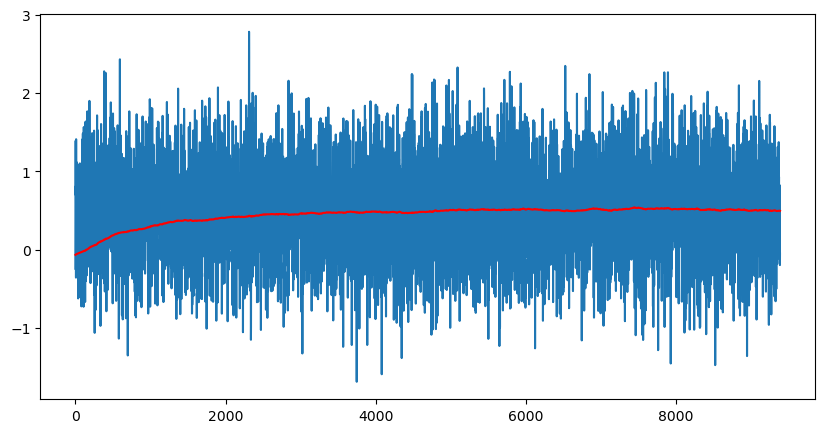

In [35]:
res = exp_smooth(X, 0.001)
plt.figure(figsize=(10, 5))
plt.plot(X)
plt.plot(res, c = 'r')
plt.show()

Взяв 1-й порядок, получим исходный сглаженный ряд, однако если взять порядок 1/100, то получится выделить тренд

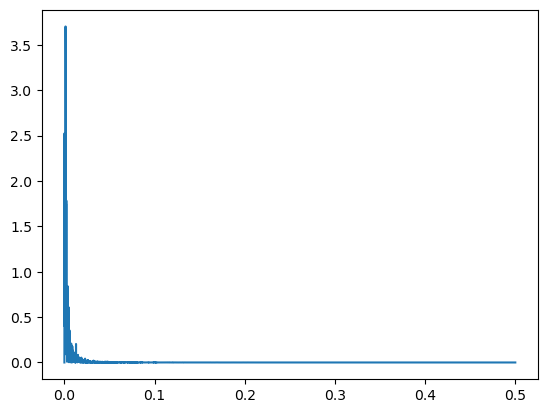

In [37]:
pd, pdden = signal.periodogram(np.array(res))
plt.plot(pd, pdden)

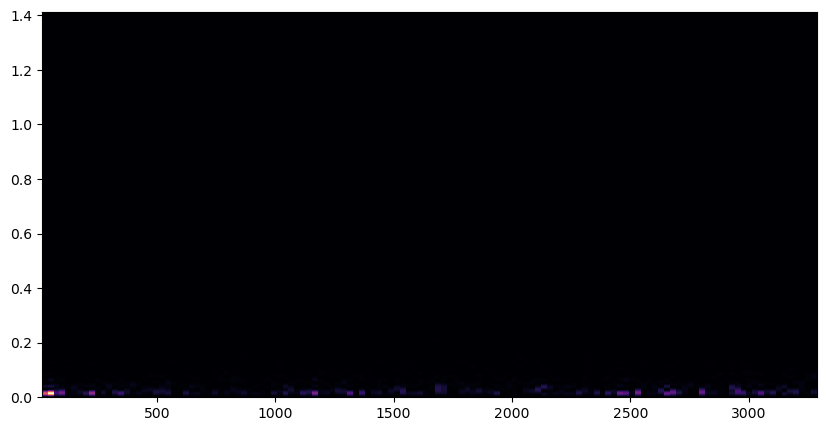

In [38]:
f, tx, Sxx = signal.spectrogram(np.array(res), fs, nperseg = 150, noverlap = 80, nfft=4096)
plt.figure(figsize = (10, 5))
plt.pcolormesh(tx, f, Sxx, shading = 'auto', cmap = 'magma')

Вейвлет-декомпозиция

In [39]:
import pywt

In [40]:
wvlt = 'dmey'
pywt.dwt_max_level(len(X), wvlt)

7

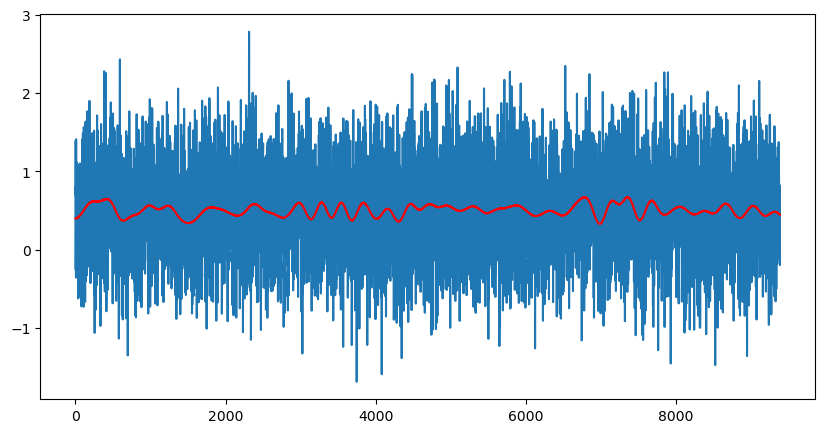

In [53]:
Mode = 'periodization'
res = pywt.wavedec(X, wvlt, mode=Mode, level=7)
res1 = pywt.waverec((res[0], None, None, None, None, None, None, None), wvlt, mode = Mode)

plt.figure(figsize = (10, 5))
plt.plot(t, X)
plt.plot(t, res1[44:-44], c = 'r')
plt.show()

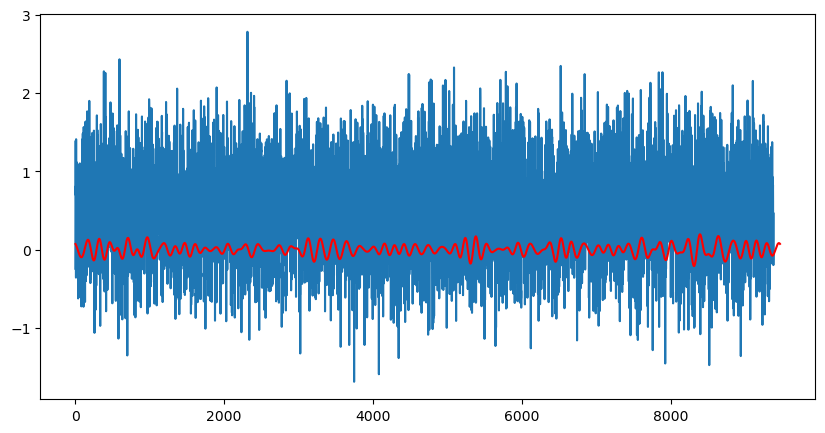

In [70]:
res1 = pywt.waverec((None, res[1], None, None, None, None, None, None), wvlt, mode = Mode)

plt.figure(figsize = (10, 5))
plt.plot(X)
plt.plot(res1, c = 'r')
plt.show()

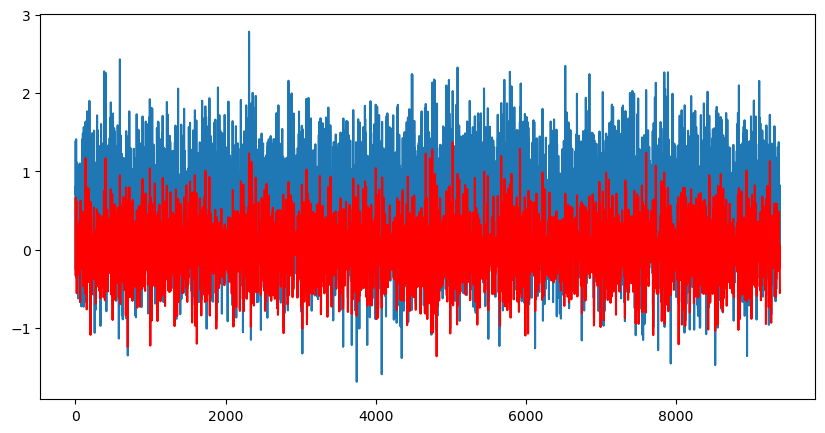

In [78]:
res1 = pywt.waverec((None, res[3], res[4], res[5], None, None), wvlt, mode = Mode)

plt.figure(figsize = (10, 5))
plt.plot(X)
plt.plot(res1, c = 'r')
plt.show()

SSA-метод

In [79]:
class SSA_dec:
    def __init__(self, F, L, I):
        self.F = F
        self.L = L
        self.I = I

    def __call__(self):
        A, U, V = self.SSA_modes(self.F, self.L)
        return self.SSA_group(A, U, V, len(self.F), self.I)
    
    def SSA_modes(self, F, L):
        N = len(F)
        K = N - L + 1
        X = np.ones((L, K))
    
        for k in range(L):
            j, m = k, k
            for i in range(j, K+m):
                X[k, i - j] = F[i]

        S = np.dot(X, X.T)
        U, A, _ = np.linalg.svd(S)
        V = np.dot(X.T, U)
    
        return (A, U, V)

    def SSA_group(self, A, U, V, N, I):
        L = len(A)
        V = V.transpose()
        K = N - L + 1
        
        Z = np.dot(U[:, I], V[I, :])
    
        lv = []
        L_min = min(L, K)
        K_max = max(L, K)
    
        for k in range(0, L_min - 1):
            s = 0
            for i in range(k+1):
                s += Z[i, k - i]
            lv.append(round(s/(k+1), 1))

        for k in range(L_min - 1, K_max):
            s = 0
            
            for i in range(L_min):
                s += Z[i, k - i]
            lv.append(round(s/(L_min), 1))
    
        for k in range(K_max, N):
            s = 0
    
            for i in range(k - K_max + 1, N - K_max + 1):
                s += Z[i, k - i]
            lv.append(round(s/(N - k), 1))

        return lv

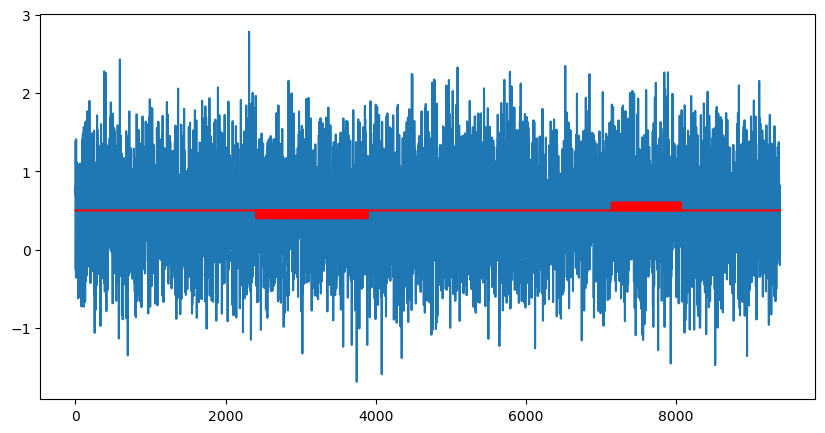

In [105]:
L = len(X)//6
I = [0, 1]
F = X

plt.figure(figsize = (10, 5))
ex = SSA_dec(F, L, I)
plt.plot(F)
plt.plot(ex(), c = 'r')

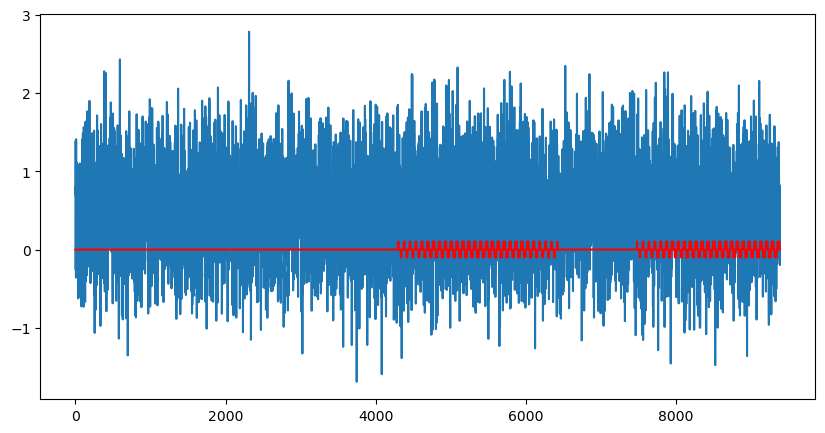

In [108]:
L = len(X)//6
I = [3, 4]
F = X

plt.figure(figsize = (10, 5))
ex = SSA_dec(F, L, I)
plt.plot(F)
plt.plot(ex(), c = 'r')

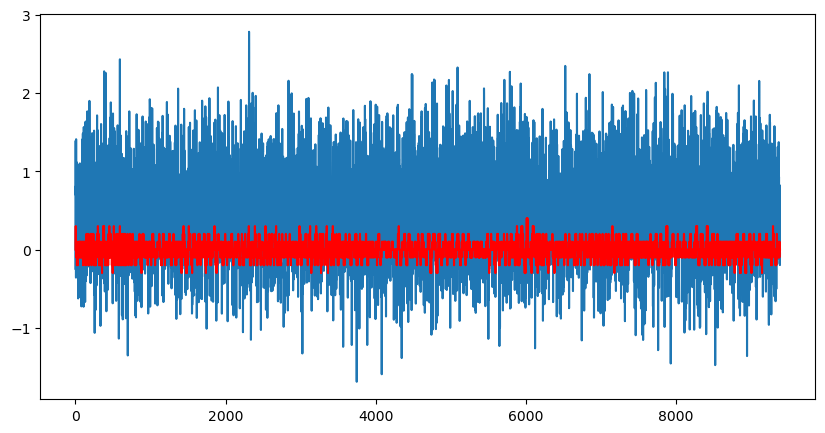

In [95]:
L = len(X)//6
I = [i for i in range(6, 16)]
F = X

plt.figure(figsize = (10, 5))
ex = SSA_dec(F, L, I)
plt.plot(F)
plt.plot(ex(), c = 'r')

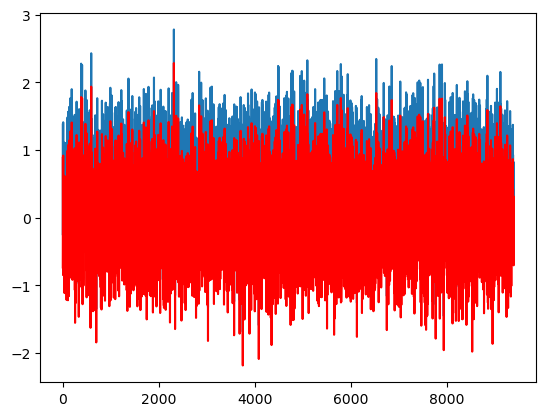

In [111]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.tsatools import detrend


X_minus_trend = detrend(X)
plt.plot(X)
plt.plot(X_minus_trend, c = 'r')

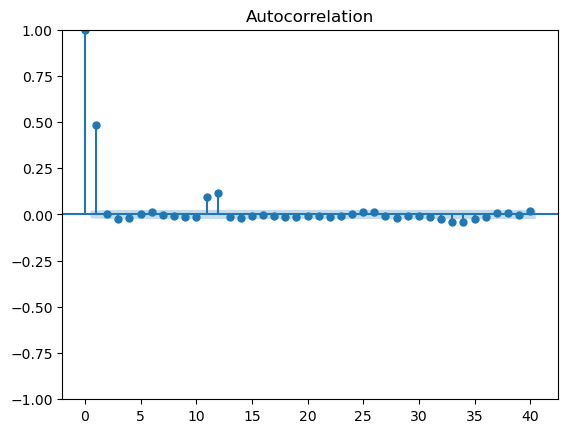

In [119]:
plot_acf(X)
plt.show()

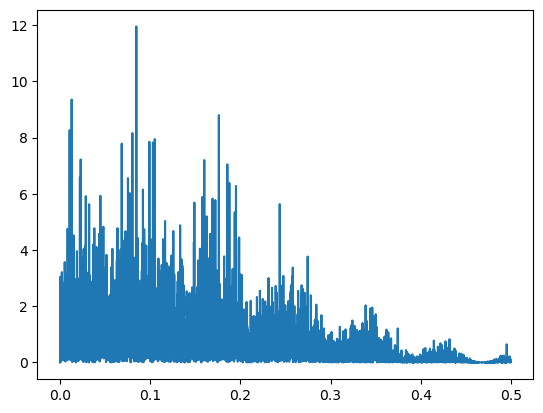

In [120]:
pd, pdden = signal.periodogram(X_minus_trend)
plt.plot(pd, pdden)

In [124]:
def param(x):
    arr = []
    for i in range(1, 3):
        for j in range(3):
            for m in range(1, 3):
                arimaz = ARIMA(x, order = (i, j, m))
                model = arimaz.fit()
                arr.append(model)


    min_bic = 9000000
    for i in arr:
        if i.bic < min_bic:
            min_bic = i.bic
            mod = i

    return mod

C:\Users\Shinik\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


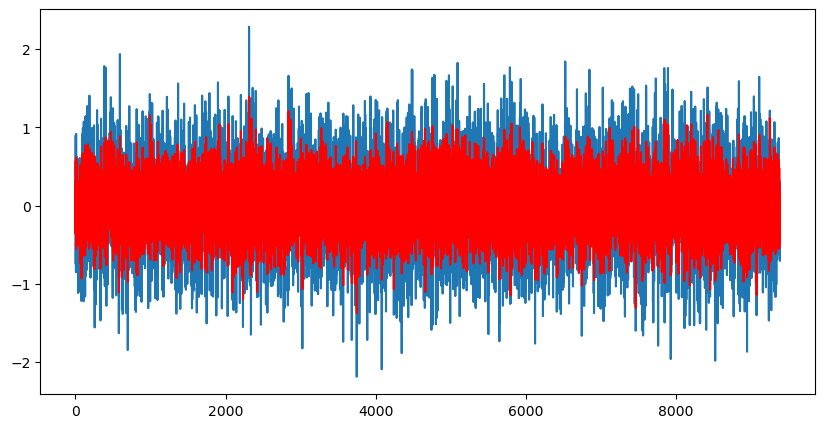

In [125]:
t = np.linspace(0, len(X_minus_trend), len(X_minus_trend))
a = param(X_minus_trend)
plt.figure(figsize = (10, 5))
plt.plot(t, X_minus_trend)
plt.plot(t, a.predict(0, len(X_minus_trend)-1), c = 'red')
plt.show()

In [127]:
a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Data   No. Observations:                 9384
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -6124.020
Date:                Mon, 27 May 2024   AIC                          12256.041
Time:                        12:57:15   BIC                          12284.628
Sample:                             0   HQIC                         12265.748
                               - 9384                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.967e-05      0.008     -0.005      0.996      -0.017       0.017
ar.L1          0.0269      0.014      1.884      0.060      -0.001       0.055
ma.L1          0.7189      0.010     73.038      0.000       0.700       0.738
sigma2         0.2159      0.003     68.261      0.000       0.210       0.222
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.25
Prob(Q):                              0.99   Prob(JB):                         0.88
Heteroskedasticity (H):               1.06   Skew:                             0.01
Prob(H) (two-sided):                  0.10   Kurtosis:                         2.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""